In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm # Gives us a cool progress bar when training :)
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import os
# Hyper parameters
BATCH_SIZE = 1000
NUM_EPOCHS = 1
LOG_RATE = 10

# Displaying our dataset
NUM_IMGS_TO_SHOW = BATCH_SIZE

MODEL_SAVE_PATH = './cifar_net.pth'

NUM_WORKERS = os.cpu_count()
# CPU vs GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can choose your gpus here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Getting the data
Currently downloading but should leave it a smaller set on the repo instead

[Transform Docs](https://pytorch.org/docs/stable/torchvision/transforms.html)

Normalize(means, stds) where means and stds are tuples with each element corresponding to a channel

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Making the loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Looking at the dataset
It's a good idea to have a look at your data to see if everything seems good.

In PyTorch iamges are represented 'channel-first' i.e. (Channels, Height, Width) or CHW

On the other hand, Tensorflow uses 'channel-last' i.e. (Height, Width, Channels) HWC

pyplot imshow expects channel-last therefore we need to transpose our image from CHW to HWC

torch.Size([3, 32, 32])


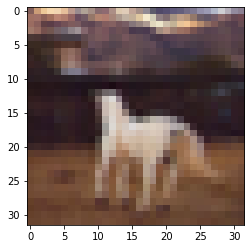

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(img.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(images[0])
# show images
# imshow(torchvision.utils.make_grid(images[NUM_IMGS_TO_SHOW]))
# print(' '.join('%5s' % classes[labels[j]] for j in range(NUM_IMGS_TO_SHOW)))

## Creating our CNN model
[Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d) (in_channels, out_channels, kernel_size)

Remember: out_channels = number of filters as by definition to be able to carry out the dot product 

[MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d) (kernel_size, stride)

[Linear](https://pytorch.org/docs/stable/nn.html#linear)
(in_features, out_features)


Note that x.view reshapes our tensor. In this example we want to reshape the output of our 2nd max pooling (after our conv2 layer) which has an output shape of (n, 16, 5, 5) into (1, 16*5*5) = (n, 400) as the fully connected 'linear' layer expects a vector shape. Where 'n' is our batch_size.

The -1 means to automatically fill the remaining dimension which in this case would get filled to 'n'.

In [9]:
## Defining our CNN Model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        return x


net = Net().to(device)

Let's look at the model summary if we feed in an RGB image of size (3, 32, 32)

In [10]:
summary(net, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Let's import and finetune a readymade model. For example the ResNet

In [20]:
from torchvision import models

# Getting resnet18 from the torchvision model zoo
resnet18 = models.resnet18(pretrained=True).to(device)

# Just 'feature extracting'
for param in resnet18.parameters():
    param.requires_grad = False
    

In [19]:
summary(resnet18, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [18]:
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes)).to(device)

In [17]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
train(resnet18)

[1,    10] loss: 2.537251568
[1,    20] loss: 2.419472909
[1,    30] loss: 2.286239076
[1,    40] loss: 2.207667828
[1,    50] loss: 2.128077030
Finished Training


In [26]:
test(resnet18)

Accuracy of the network on the 10000 test images: 24 %


## Training

In [11]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % LOG_RATE == LOG_RATE - 1:    # print every LOG_RATE mini-batches
                print('[%d, %5d] loss: %.9f' %
                      (epoch + 1, i + 1, running_loss / LOG_RATE))
                running_loss = 0.0

    print('Finished Training')

In [ ]:
torch.save(net.state_dict(), MODEL_SAVE_PATH)

In [12]:
train(net)

[1,    10] loss: 2.304206991
[1,    20] loss: 2.304518533
[1,    30] loss: 2.302389884
[1,    40] loss: 2.304218841
[1,    50] loss: 2.302620554
Finished Training


# Testing

Looking at our predictions using the our 'net' model

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [14]:
def test(model):
    # total accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [15]:
test(net)

Accuracy of the network on the 10000 test images: 10 %
